# Makine Öğrenmesi ile AAPL Hisse Senedi Modelleme

Bu notebook, Apple (AAPL) hisse senedi için logaritmik getiri tahmininde çeşitli makine öğrenmesi yöntemlerini içermektedir.

**Veri:** Doldurulmuş (filled) AAPL verisi - Logaritmik getiri ile çalışılmaktadır.

**Modeller:**
1. Linear Regression (Doğrusal Regresyon)
2. Random Forest (Rastgele Orman)
3. Gradient Boosting (Gradient Artırma)
4. k-Nearest Neighbors (k-En Yakın Komşu)
5. CNN (Konvolüsyonel Sinir Ağı)

## 1. Kütüphaneler ve Veri Yükleme

In [1]:
# Genel kütüphaneler
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# Scikit-learn
from sklearn.model_selection import train_test_split, TimeSeriesSplit
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# TensorFlow/Keras (CNN için)
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, Dense, Flatten, Dropout
from tensorflow.keras.callbacks import EarlyStopping

# Görselleştirme ayarları
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette('husl')
%matplotlib inline

In [2]:
# Veri yükleme
data = pd.read_csv('../data/filled_aapl.csv', parse_dates=['Date'], index_col='Date')
data.index = pd.to_datetime(data.index, utc=True)

print(f"Veri boyutu: {data.shape}")
print(f"Tarih aralığı: {data.index.min().date()} - {data.index.max().date()}")
print(f"\nİlk 5 kayıt:")
data.head()

Veri boyutu: (11686, 7)
Tarih aralığı: 1980-12-12 - 2025-09-26

İlk 5 kayıt:


,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
1980-12-12 05:00:00+00:00,0.098485,0.098913,0.098485,0.098485,469033600.0,0.0,0.0
1980-12-15 05:00:00+00:00,0.093775,0.093775,0.093347,0.093347,175884800.0,0.0,0.0
1980-12-16 05:00:00+00:00,0.086924,0.086924,0.086495,0.086495,105728000.0,0.0,0.0
1980-12-17 05:00:00+00:00,0.088636,0.089064,0.088636,0.088636,86441600.0,0.0,0.0
1980-12-18 05:00:00+00:00,0.091206,0.091634,0.091206,0.091206,73449600.0,0.0,0.0


## 2. Özellik Mühendisliği

Bu bölümde, ham fiyat verilerinden makine öğrenmesi modellerine girdi olacak özellikler türetilecektir:

**Türetilecek Özellikler:**
1. **Logaritmik getiri**: Günlük fiyat değişimleri
2. **Gecikmeli getiriler**: Önceki 5 günün getirileri (otoregresif özellikler)
3. **Volatilite göstergeleri**: 5 ve 10 günlük hareketli standart sapma
4. **Momentum göstergeleri**: 5 ve 10 günlük fiyat değişimleri
5. **RSI**: 14 günlük Relative Strength Index (teknik analiz göstergesi)

In [3]:
# Logaritmik getiri hesaplama
data['logret'] = np.log(data['Close'] / data['Close'].shift(1))

# Gecikmeli (lag) özellikler - Önceki günlerin getirilerini kullan
for i in range(1, 6):
    data[f'logret_lag{i}'] = data['logret'].shift(i)

# Hareketli ortalamalar
data['MA_5'] = data['Close'].rolling(window=5).mean()
data['MA_10'] = data['Close'].rolling(window=10).mean()
data['MA_20'] = data['Close'].rolling(window=20).mean()

# Hareketli standart sapma (volatilite)
data['volatility_5'] = data['logret'].rolling(window=5).std()
data['volatility_10'] = data['logret'].rolling(window=10).std()

# Momentum göstergeleri
data['momentum_5'] = data['Close'] - data['Close'].shift(5)
data['momentum_10'] = data['Close'] - data['Close'].shift(10)

# RSI (Relative Strength Index) basitleştirilmiş
delta = data['Close'].diff()
gain = (delta.where(delta > 0, 0)).rolling(window=14).mean()
loss = (-delta.where(delta < 0, 0)).rolling(window=14).mean()
rs = gain / loss
data['RSI'] = 100 - (100 / (1 + rs))

# Eksik değerleri temizle
data = data.dropna()

print(f"Özellik mühendisliği sonrası veri boyutu: {data.shape}")
print(f"\nÖzellikler: {data.columns.tolist()}")

Özellik mühendisliği sonrası veri boyutu: (11667, 21)

Özellikler: ['Open', 'High', 'Low', 'Close', 'Volume', 'Dividends', 'Stock Splits', 'logret', 'logret_lag1', 'logret_lag2', 'logret_lag3', 'logret_lag4', 'logret_lag5', 'MA_5', 'MA_10', 'MA_20', 'volatility_5', 'volatility_10', 'momentum_5', 'momentum_10', 'RSI']


## 3. Veri Hazırlama

Bu bölümde, modelleme için hedef değişken ve özellikler hazırlanacaktır.

## 3.1. Özellikler ve Hedef Değişken Tanımları

### Hedef Değişken (Target Variable):
**`target`**: Bir sonraki günün logaritmik getirisi
- **Formül**: `target = log(Close_t+1 / Close_t)`
- **Açıklama**: Modelin tahmin etmeye çalıştığı değişken. Bir gün sonraki kapanış fiyatının logaritmik getirisi.
- **Neden logaritmik getiri?** 
  - Stationary (durağan) özellik gösterir
  - Yüzdesel değişimleri daha iyi temsil eder
  - Matematiksel olarak işlem yapmaya daha uygundur

---

### Giriş Özellikleri (Input Features):

#### 1. Gecikmeli Logaritmik Getiriler (Lagged Returns)
- **`logret_lag1`**: 1 gün önceki logaritmik getiri
- **`logret_lag2`**: 2 gün önceki logaritmik getiri
- **`logret_lag3`**: 3 gün önceki logaritmik getiri
- **`logret_lag4`**: 4 gün önceki logaritmik getiri
- **`logret_lag5`**: 5 gün önceki logaritmik getiri

**Amaç**: Geçmiş getiri trendlerini ve momentum etkilerini yakalamak. Otoregresif (AR) bir yapı oluşturarak zaman serisi bağımlılığını modele dahil etmek.

#### 2. Volatilite Göstergeleri (Volatility Indicators)
- **`volatility_5`**: Son 5 günlük logaritmik getirilerin standart sapması
- **`volatility_10`**: Son 10 günlük logaritmik getirilerin standart sapması

**Amaç**: Piyasa oynaklığını (risk seviyesini) ölçmek. Yüksek volatilite dönemleri genellikle büyük fiyat hareketleriyle ilişkilidir.

#### 3. Momentum Göstergeleri (Momentum Indicators)
- **`momentum_5`**: 5 günlük fiyat değişimi = `Close_t - Close_t-5`
- **`momentum_10`**: 10 günlük fiyat değişimi = `Close_t - Close_t-10`

**Amaç**: Fiyat hareketinin hızını ve yönünü ölçmek. Pozitif momentum yükseliş, negatif momentum düşüş eğilimini gösterir.

#### 4. RSI (Relative Strength Index)
- **`RSI`**: 14 günlük göreceli güç endeksi (0-100 arası değer)
- **Formül**: 
  - Kazançların ortalaması (14 gün)
  - Kayıpların ortalaması (14 gün)
  - RS = Kazanç Ort. / Kayıp Ort.
  - RSI = 100 - (100 / (1 + RS))

**Amaç**: Aşırı alım (>70) ve aşırı satım (<30) bölgelerini tespit etmek. Momentum göstergesi olarak trend dönüş noktalarını yakalamaya yardımcı olur.

---

### Özellik Sayısı
**Toplam 10 özellik** modellere girdi olarak verilmektedir:
- 5 gecikmeli getiri
- 2 volatilite göstergesi
- 2 momentum göstergesi
- 1 RSI göstergesi

### Veri Ön İşleme
- **Ölçeklendirme**: StandardScaler (ortalama=0, std=1) ile tüm özellikler normalize edilmiştir
- **Eksik Değerler**: Özellik hesaplamaları sonrası oluşan NaN değerler temizlenmiştir
- **Train-Test Split**: Zaman serisi yapısı korunarak son %20 test seti olarak ayrılmıştır

In [4]:
# Hedef değişken: Bir sonraki günün logaritmik getirisi
data['target'] = data['logret'].shift(-1)
data = data.dropna()

# Özellik seçimi
feature_cols = ['logret_lag1', 'logret_lag2', 'logret_lag3', 'logret_lag4', 'logret_lag5',
                'volatility_5', 'volatility_10', 'momentum_5', 'momentum_10', 'RSI']

X = data[feature_cols]
y = data['target']

print(f"X shape: {X.shape}")
print(f"y shape: {y.shape}")
print(f"\nÖzellikler:\n{feature_cols}")

X shape: (11666, 10)
y shape: (11666,)

Özellikler:
['logret_lag1', 'logret_lag2', 'logret_lag3', 'logret_lag4', 'logret_lag5', 'volatility_5', 'volatility_10', 'momentum_5', 'momentum_10', 'RSI']


In [5]:
# Veriyi eğitim ve test setlerine ayırma (zaman serisi için son %20 test)
split_idx = int(len(X) * 0.8)

X_train, X_test = X.iloc[:split_idx], X.iloc[split_idx:]
y_train, y_test = y.iloc[:split_idx], y.iloc[split_idx:]

print(f"Eğitim seti: {X_train.shape[0]} gözlem")
print(f"Test seti: {X_test.shape[0]} gözlem")
print(f"Test oranı: {X_test.shape[0]/len(X)*100:.1f}%")

Eğitim seti: 9332 gözlem
Test seti: 2334 gözlem
Test oranı: 20.0%


In [6]:
# Özellik ölçeklendirme (Standardization)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("Veri ölçeklendirme tamamlandı.")

Veri ölçeklendirme tamamlandı.


## 4. Model Performans Değerlendirme Fonksiyonu

In [7]:
def evaluate_model(y_true, y_pred, model_name):
    """
    Model performansını değerlendir ve görselleştir.
    """
    # Metrikler
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    
    # Yön doğruluğu (directional accuracy)
    actual_direction = np.sign(y_true)
    pred_direction = np.sign(y_pred)
    direction_accuracy = np.mean(actual_direction == pred_direction) * 100
    
    print(f"\n{'='*60}")
    print(f"{model_name} - Test Performansı")
    print(f"{'='*60}")
    print(f"RMSE (Root Mean Squared Error): {rmse:.6f}")
    print(f"MAE (Mean Absolute Error):      {mae:.6f}")
    print(f"R² Score:                        {r2:.6f}")
    print(f"Yön Doğruluğu:                   {direction_accuracy:.2f}%")
    print(f"{'='*60}")
    
    # Görselleştirme
    fig, axes = plt.subplots(1, 3, figsize=(16, 4))
    
    # 1. Gerçek vs Tahmin
    axes[0].scatter(y_true, y_pred, alpha=0.3, s=10)
    axes[0].plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], 
                 'r--', lw=2, label='Perfect Prediction')
    axes[0].set_xlabel('Gerçek Değer')
    axes[0].set_ylabel('Tahmin')
    axes[0].set_title(f'{model_name}\nGerçek vs Tahmin')
    axes[0].legend()
    axes[0].grid(alpha=0.3)
    
    # 2. Zaman serisi karşılaştırması (ilk 200 gözlem)
    n_show = min(200, len(y_true))
    axes[1].plot(range(n_show), y_true.values[:n_show], label='Gerçek', alpha=0.7, linewidth=1.5)
    axes[1].plot(range(n_show), y_pred[:n_show], label='Tahmin', alpha=0.7, linewidth=1.5)
    axes[1].set_xlabel('Zaman')
    axes[1].set_ylabel('Logaritmik Getiri')
    axes[1].set_title(f'{model_name}\nZaman Serisi (İlk {n_show} Gözlem)')
    axes[1].legend()
    axes[1].grid(alpha=0.3)
    
    # 3. Hata dağılımı
    errors = y_true - y_pred
    axes[2].hist(errors, bins=50, edgecolor='black', alpha=0.7)
    axes[2].axvline(0, color='red', linestyle='--', linewidth=2)
    axes[2].set_xlabel('Hata (Gerçek - Tahmin)')
    axes[2].set_ylabel('Frekans')
    axes[2].set_title(f'{model_name}\nHata Dağılımı')
    axes[2].grid(alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    return {'RMSE': rmse, 'MAE': mae, 'R2': r2, 'Direction_Accuracy': direction_accuracy}

---
# MODEL 1: Linear Regression (Doğrusal Regresyon)

**Açıklama:**  
Doğrusal regresyon, hedef değişken ile özellikler arasında doğrusal bir ilişki varsayar. Basit ve yorumlanabilir bir yöntemdir.

**Avantajlar:**
- Hızlı ve kolay uygulanabilir
- Katsayılar yorumlanabilir

**Dezavantajlar:**
- Doğrusal olmayan ilişkileri yakalayamaz
- Finansal verilerdeki karmaşık desenler için yetersiz kalabilir


Linear Regression - Test Performansı
RMSE (Root Mean Squared Error): 0.018737
MAE (Mean Absolute Error):      0.012940
R² Score:                        -0.046340
Yön Doğruluğu:                   49.31%


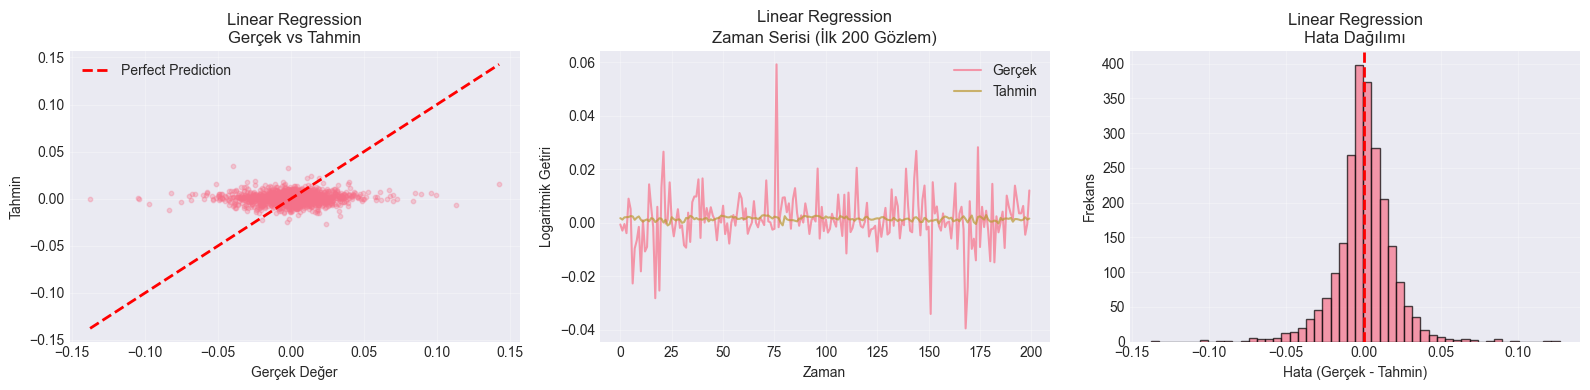

In [8]:
# Linear Regression modeli
lr_model = LinearRegression()
lr_model.fit(X_train_scaled, y_train)

# Tahmin
y_pred_lr = lr_model.predict(X_test_scaled)

# Değerlendirme
lr_results = evaluate_model(y_test, y_pred_lr, 'Linear Regression')


=== Linear Regression - Özellik Katsayıları ===
      Özellik   Katsayı
  logret_lag2 -0.001255
          RSI  0.000757
  logret_lag1 -0.000756
  logret_lag3  0.000476
  momentum_10 -0.000379
volatility_10 -0.000346
 volatility_5 -0.000300
   momentum_5  0.000190
  logret_lag5  0.000161
  logret_lag4  0.000115


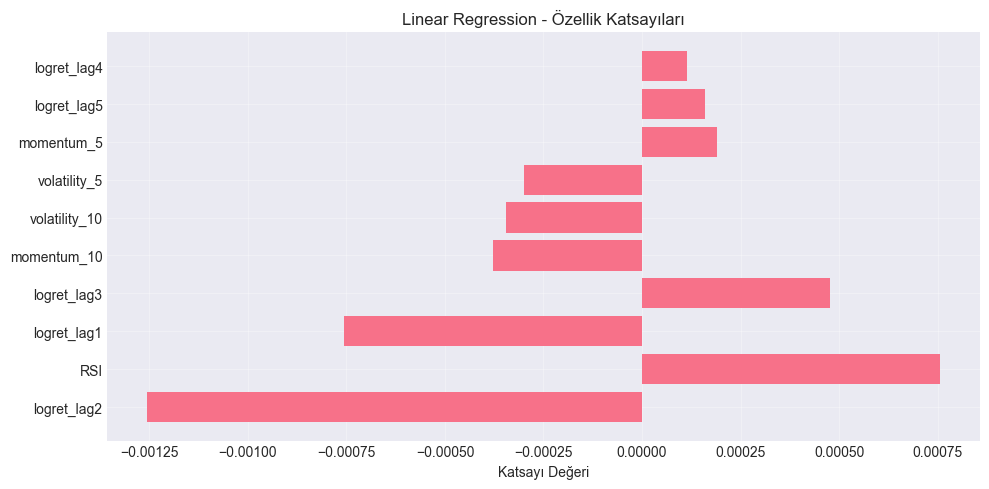

In [9]:
# Özellik önem dereceleri (katsayılar)
coefficients = pd.DataFrame({
    'Özellik': feature_cols,
    'Katsayı': lr_model.coef_
}).sort_values('Katsayı', key=abs, ascending=False)

print("\n=== Linear Regression - Özellik Katsayıları ===")
print(coefficients.to_string(index=False))

# Görselleştirme
plt.figure(figsize=(10, 5))
plt.barh(coefficients['Özellik'], coefficients['Katsayı'])
plt.xlabel('Katsayı Değeri')
plt.title('Linear Regression - Özellik Katsayıları')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

---
# MODEL 2: Random Forest (Rastgele Orman)

**Açıklama:**  
Random Forest, birçok karar ağacını birleştirerek çalışan bir ensemble yöntemidir. Doğrusal olmayan ilişkileri yakalayabilir.

**Avantajlar:**
- Doğrusal olmayan ilişkileri yakalayabilir
- Overfitting'e karşı dirençli
- Özellik önemliliği hesaplayabilir

**Dezavantajlar:**
- Yorumlaması daha zor
- Hesaplama maliyeti daha yüksek


Random Forest - Test Performansı
RMSE (Root Mean Squared Error): 0.018401
MAE (Mean Absolute Error):      0.012449
R² Score:                        -0.009105
Yön Doğruluğu:                   50.30%


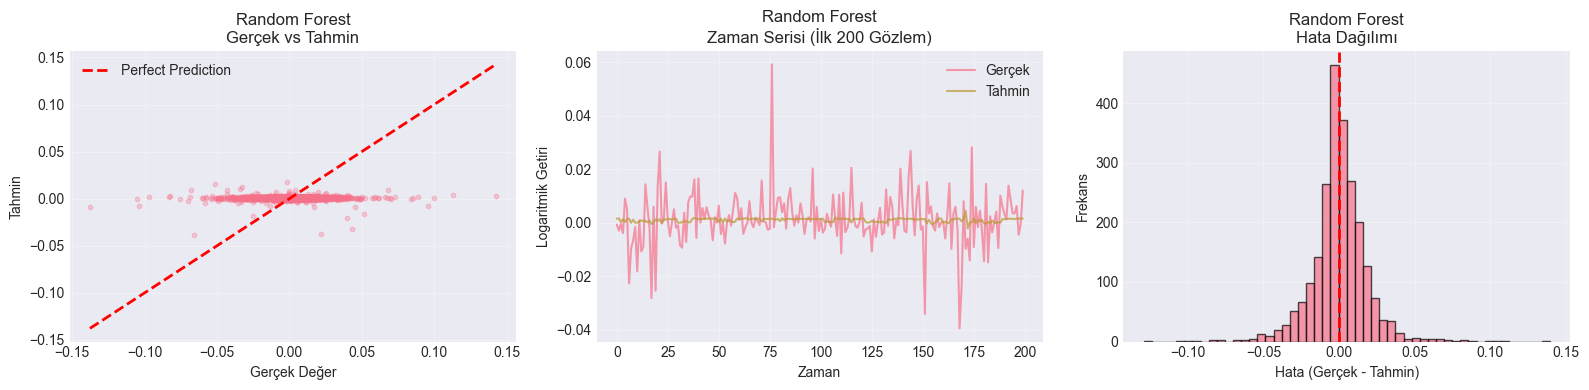

In [10]:
# Random Forest modeli
rf_model = RandomForestRegressor(
    n_estimators=100,
    max_depth=10,
    min_samples_split=10,
    min_samples_leaf=5,
    random_state=42,
    n_jobs=-1
)

rf_model.fit(X_train_scaled, y_train)

# Tahmin
y_pred_rf = rf_model.predict(X_test_scaled)

# Değerlendirme
rf_results = evaluate_model(y_test, y_pred_rf, 'Random Forest')


=== Random Forest - Özellik Önemliliği ===
      Özellik     Önem
  logret_lag5 0.143518
  logret_lag4 0.132868
  logret_lag1 0.125865
 volatility_5 0.125119
  logret_lag2 0.123753
  logret_lag3 0.101467
volatility_10 0.077233
   momentum_5 0.069442
          RSI 0.058304
  momentum_10 0.042431


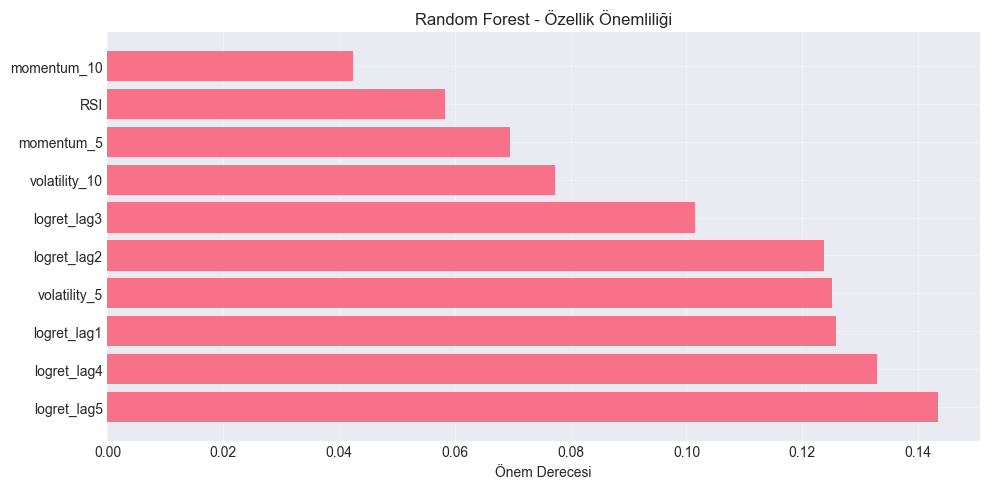

In [11]:
# Özellik önemliliği
feature_importance = pd.DataFrame({
    'Özellik': feature_cols,
    'Önem': rf_model.feature_importances_
}).sort_values('Önem', ascending=False)

print("\n=== Random Forest - Özellik Önemliliği ===")
print(feature_importance.to_string(index=False))

# Görselleştirme
plt.figure(figsize=(10, 5))
plt.barh(feature_importance['Özellik'], feature_importance['Önem'])
plt.xlabel('Önem Derecesi')
plt.title('Random Forest - Özellik Önemliliği')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

---
# MODEL 3: Gradient Boosting

**Açıklama:**  
Gradient Boosting, zayıf öğrenicileri (genellikle karar ağaçları) sırayla birleştirerek güçlü bir model oluşturur. Her yeni ağaç, önceki ağaçların hatalarını düzeltmeye çalışır.

**Avantajlar:**
- Yüksek tahmin performansı
- Doğrusal olmayan ilişkileri çok iyi yakalar
- Özellik önemliliği sağlar

**Dezavantajlar:**
- Overfitting riski (özellikle küçük veri setlerinde)
- Eğitim süresi uzun olabilir


Gradient Boosting - Test Performansı
RMSE (Root Mean Squared Error): 0.018590
MAE (Mean Absolute Error):      0.012687
R² Score:                        -0.029926
Yön Doğruluğu:                   50.73%


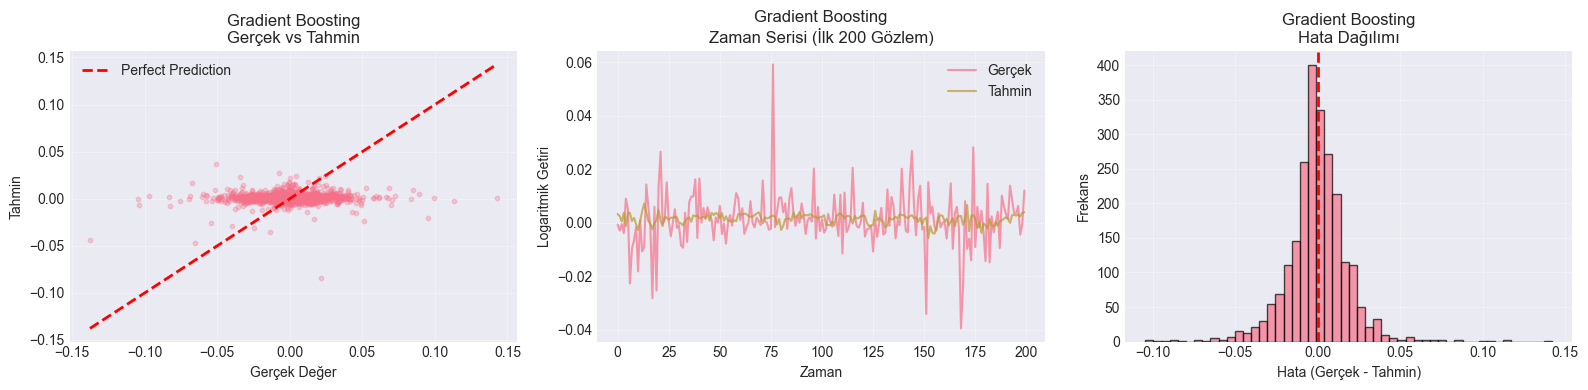

In [12]:
# Gradient Boosting modeli
gb_model = GradientBoostingRegressor(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=5,
    min_samples_split=10,
    min_samples_leaf=5,
    subsample=0.8,
    random_state=42
)

gb_model.fit(X_train_scaled, y_train)

# Tahmin
y_pred_gb = gb_model.predict(X_test_scaled)

# Değerlendirme
gb_results = evaluate_model(y_test, y_pred_gb, 'Gradient Boosting')


=== Gradient Boosting - Özellik Önemliliği ===
      Özellik     Önem
  logret_lag5 0.151493
  logret_lag4 0.140645
  logret_lag2 0.118838
  logret_lag1 0.118263
  logret_lag3 0.102273
 volatility_5 0.091297
   momentum_5 0.082250
volatility_10 0.080939
          RSI 0.060826
  momentum_10 0.053176


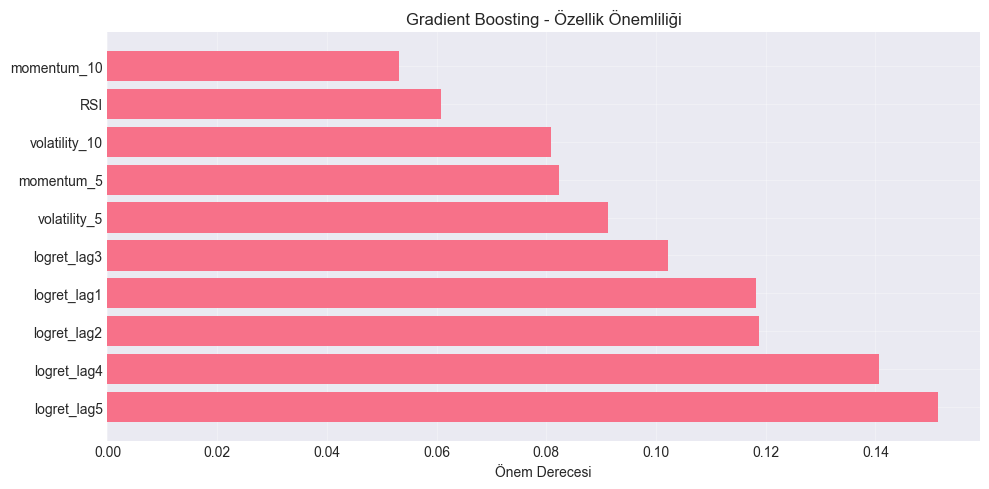

In [13]:
# Özellik önemliliği
feature_importance_gb = pd.DataFrame({
    'Özellik': feature_cols,
    'Önem': gb_model.feature_importances_
}).sort_values('Önem', ascending=False)

print("\n=== Gradient Boosting - Özellik Önemliliği ===")
print(feature_importance_gb.to_string(index=False))

# Görselleştirme
plt.figure(figsize=(10, 5))
plt.barh(feature_importance_gb['Özellik'], feature_importance_gb['Önem'])
plt.xlabel('Önem Derecesi')
plt.title('Gradient Boosting - Özellik Önemliliği')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

---
# MODEL 4: k-Nearest Neighbors (k-En Yakın Komşu)

**Açıklama:**  
kNN, bir gözlemin tahminini, özellik uzayında ona en yakın k komşusunun ortalaması alarak yapar. Model tabanlı değil, örnek tabanlı bir yöntemdir.

**Avantajlar:**
- Basit ve sezgisel
- Parametrik olmayan (veri dağılımı varsayımı yok)

**Dezavantajlar:**
- Büyük veri setlerinde yavaş
- Ölçeklendirmeye duyarlı
- Yüksek boyutlu verilerde performans düşer


k-Nearest Neighbors - Test Performansı
RMSE (Root Mean Squared Error): 0.018754
MAE (Mean Absolute Error):      0.012908
R² Score:                        -0.048191
Yön Doğruluğu:                   49.06%


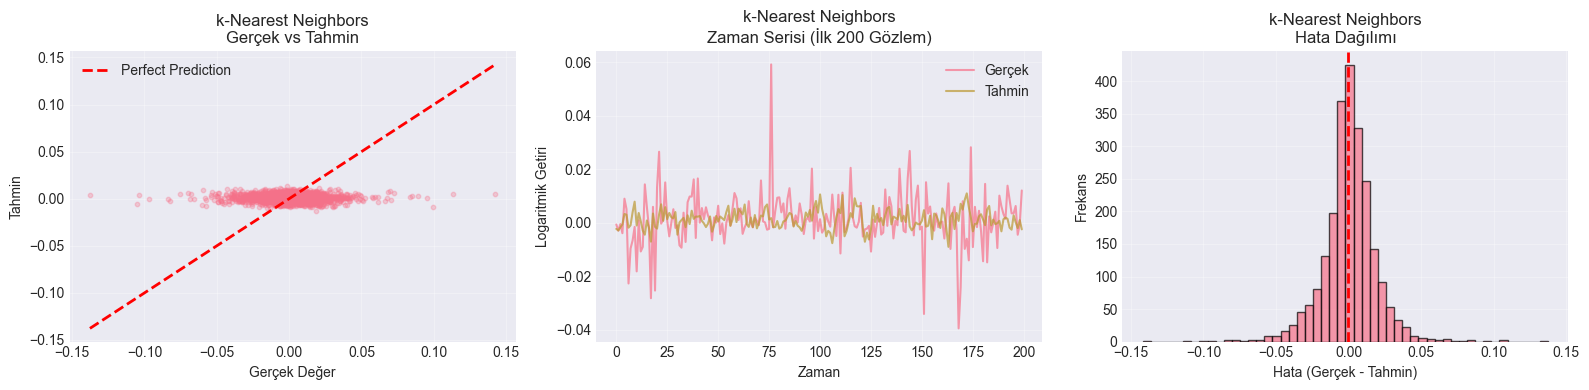

In [14]:
# k-Nearest Neighbors modeli
knn_model = KNeighborsRegressor(
    n_neighbors=20,
    weights='distance',  # Mesafeye göre ağırlıklandırma
    metric='euclidean'
)

knn_model.fit(X_train_scaled, y_train)

# Tahmin
y_pred_knn = knn_model.predict(X_test_scaled)

# Değerlendirme
knn_results = evaluate_model(y_test, y_pred_knn, 'k-Nearest Neighbors')

---
# MODEL 5: CNN (Convolutional Neural Network)

**Açıklama:**  
CNN, orijinal olarak görüntü işleme için geliştirilmiş bir derin öğrenme modelidir. Zaman serilerinde lokal desenler yakalamak için de kullanılabilir.

**Avantajlar:**
- Zaman serilerindeki lokal desenler ve ardışık bağımlılıkları yakalayabilir
- Doğrusal olmayan karmaşık ilişkileri öğrenebilir

**Dezavantajlar:**
- Eğitim süresi uzun
- Hiperparametre ayarlaması gerekir
- Yorumlaması zor (black-box)

In [15]:
# CNN için veriyi 3D formata dönüştür: (samples, timesteps, features)
# Her özellik bir "timestep" olarak düşünülecek
X_train_cnn = X_train_scaled.reshape(X_train_scaled.shape[0], X_train_scaled.shape[1], 1)
X_test_cnn = X_test_scaled.reshape(X_test_scaled.shape[0], X_test_scaled.shape[1], 1)

print(f"CNN veri şekli:")
print(f"X_train_cnn: {X_train_cnn.shape}")
print(f"X_test_cnn: {X_test_cnn.shape}")

CNN veri şekli:
X_train_cnn: (9332, 10, 1)
X_test_cnn: (2334, 10, 1)


In [16]:
# CNN modeli oluşturma
cnn_model = Sequential([
    Conv1D(filters=64, kernel_size=2, activation='relu', input_shape=(X_train_cnn.shape[1], 1)),
    Conv1D(filters=32, kernel_size=2, activation='relu'),
    Flatten(),
    Dense(50, activation='relu'),
    Dropout(0.2),
    Dense(1)  # Çıkış katmanı (regresyon)
])

cnn_model.compile(optimizer='adam', loss='mse', metrics=['mae'])

print("\n=== CNN Model Mimarisi ===")
cnn_model.summary()


=== CNN Model Mimarisi ===


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 9, 64)          │           192 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 8, 32)          │         4,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 50)             │        12,850 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 17,221 (67.27 KB)

 Trainable params: 17,221 (67.27 KB)

 Non-trainable params: 0 (0.00 B)

In [17]:
# Early stopping callback (eğitimde iyileşme olmazsa durdurmak için)
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Model eğitimi
print("\nCNN modeli eğitiliyor...")
history = cnn_model.fit(
    X_train_cnn, y_train,
    epochs=50,
    batch_size=32,
    validation_split=0.2,
    callbacks=[early_stop],
    verbose=1
)

print("\nCNN eğitimi tamamlandı!")


CNN modeli eğitiliyor...
Epoch 1/50
234/234 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.0024 - mae: 0.0296 - val_loss: 3.8735e-04 - val_mae: 0.0143
Epoch 2/50
234/234 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.0024 - mae: 0.0296 - val_loss: 3.8735e-04 - val_mae: 0.0143
Epoch 2/50
234/234 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0011 - mae: 0.0225 - val_loss: 3.4040e-04 - val_mae: 0.0132
Epoch 3/50
234/234 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0011 - mae: 0.0225 - val_loss: 3.4040e-04 - val_mae: 0.0132
Epoch 3/50
234/234 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0010 - mae: 0.0220 - val_loss: 3.5288e-04 - val_mae: 0.0135
Epoch 4/50
234/234 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0010 - mae: 0.0220 - val_loss: 3.5288e-04 - val_mae: 0.0135
Epoch 4/50
234/234 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0010 - mae: 0.0221 - val_loss: 3.6472e-04 - val_mae: 0.0137
Epoch 5/50
234/234 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0010 - mae: 0.0221 - val_loss: 3.6472e-04 - val_mae: 0.013

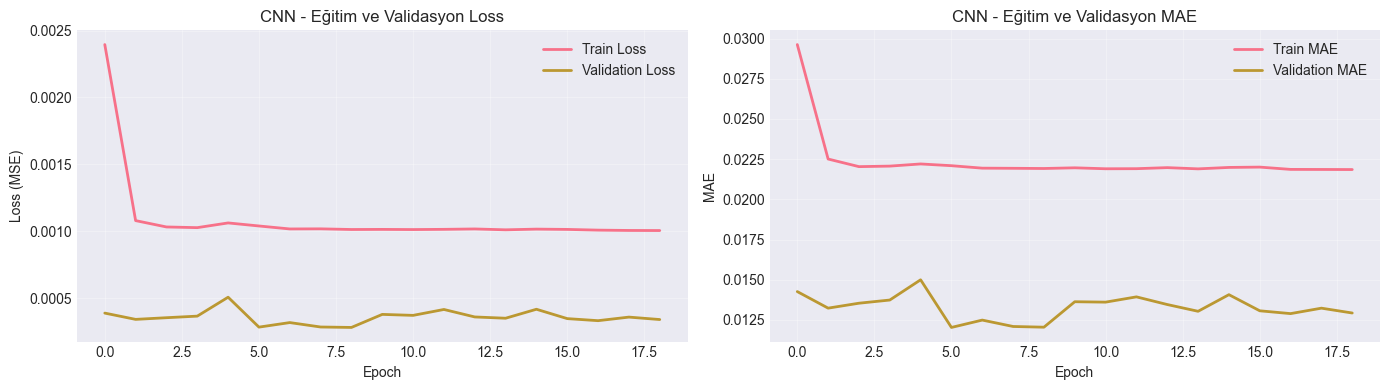

In [18]:
# Eğitim geçmişi görselleştirme
fig, axes = plt.subplots(1, 2, figsize=(14, 4))

# Loss
axes[0].plot(history.history['loss'], label='Train Loss', linewidth=2)
axes[0].plot(history.history['val_loss'], label='Validation Loss', linewidth=2)
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss (MSE)')
axes[0].set_title('CNN - Eğitim ve Validasyon Loss')
axes[0].legend()
axes[0].grid(alpha=0.3)

# MAE
axes[1].plot(history.history['mae'], label='Train MAE', linewidth=2)
axes[1].plot(history.history['val_mae'], label='Validation MAE', linewidth=2)
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('MAE')
axes[1].set_title('CNN - Eğitim ve Validasyon MAE')
axes[1].legend()
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()


CNN - Test Performansı
RMSE (Root Mean Squared Error): 0.104939
MAE (Mean Absolute Error):      0.054797
R² Score:                        -31.820226
Yön Doğruluğu:                   48.54%


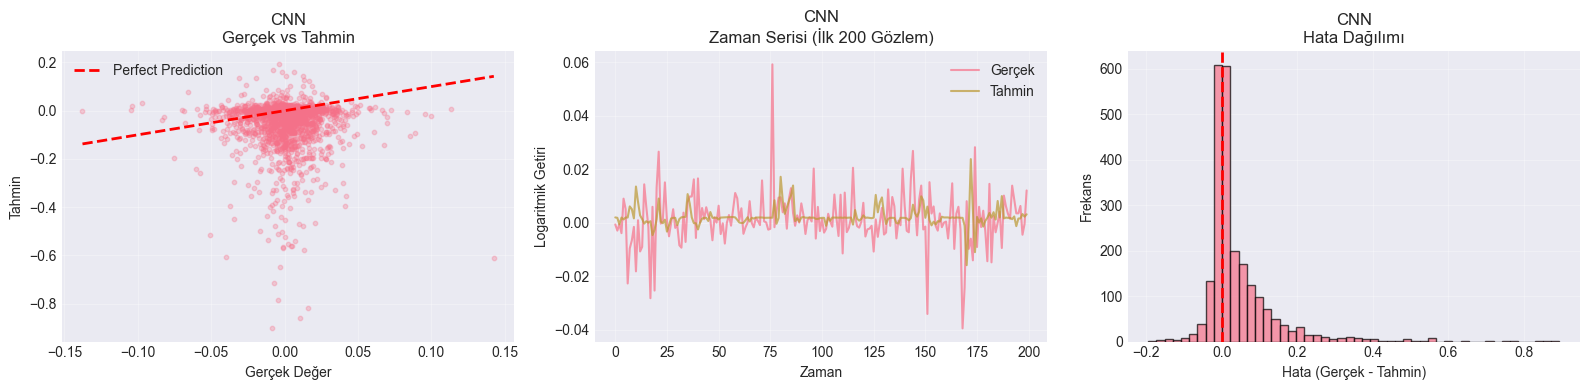

In [19]:
# CNN tahminleri
y_pred_cnn = cnn_model.predict(X_test_cnn, verbose=0).flatten()

# Değerlendirme
cnn_results = evaluate_model(y_test, y_pred_cnn, 'CNN')

---
# 5. Model Karşılaştırması

Tüm modellerin performansını karşılaştırıyoruz.

In [20]:
# Tüm sonuçları toplama
results_df = pd.DataFrame({
    'Model': ['Linear Regression', 'Random Forest', 'Gradient Boosting', 'k-Nearest Neighbors', 'CNN'],
    'RMSE': [lr_results['RMSE'], rf_results['RMSE'], gb_results['RMSE'], 
             knn_results['RMSE'], cnn_results['RMSE']],
    'MAE': [lr_results['MAE'], rf_results['MAE'], gb_results['MAE'], 
            knn_results['MAE'], cnn_results['MAE']],
    'R²': [lr_results['R2'], rf_results['R2'], gb_results['R2'], 
           knn_results['R2'], cnn_results['R2']],
    'Yön Doğruluğu (%)': [lr_results['Direction_Accuracy'], rf_results['Direction_Accuracy'], 
                           gb_results['Direction_Accuracy'], knn_results['Direction_Accuracy'], 
                           cnn_results['Direction_Accuracy']]
})

# RMSE'ye göre sıralama (düşük daha iyi)
results_df = results_df.sort_values('RMSE')

print("\n" + "="*80)
print("MODEL KARŞILAŞTIRMASI - PERFORMANS SONUÇLARI")
print("="*80)
print(results_df.to_string(index=False))
print("="*80)


MODEL KARŞILAŞTIRMASI - PERFORMANS SONUÇLARI
              Model     RMSE      MAE         R²  Yön Doğruluğu (%)
      Random Forest 0.018401 0.012449  -0.009105          50.299914
  Gradient Boosting 0.018590 0.012687  -0.029926          50.728363
  Linear Regression 0.018737 0.012940  -0.046340          49.314482
k-Nearest Neighbors 0.018754 0.012908  -0.048191          49.057412
                CNN 0.104939 0.054797 -31.820226          48.543273


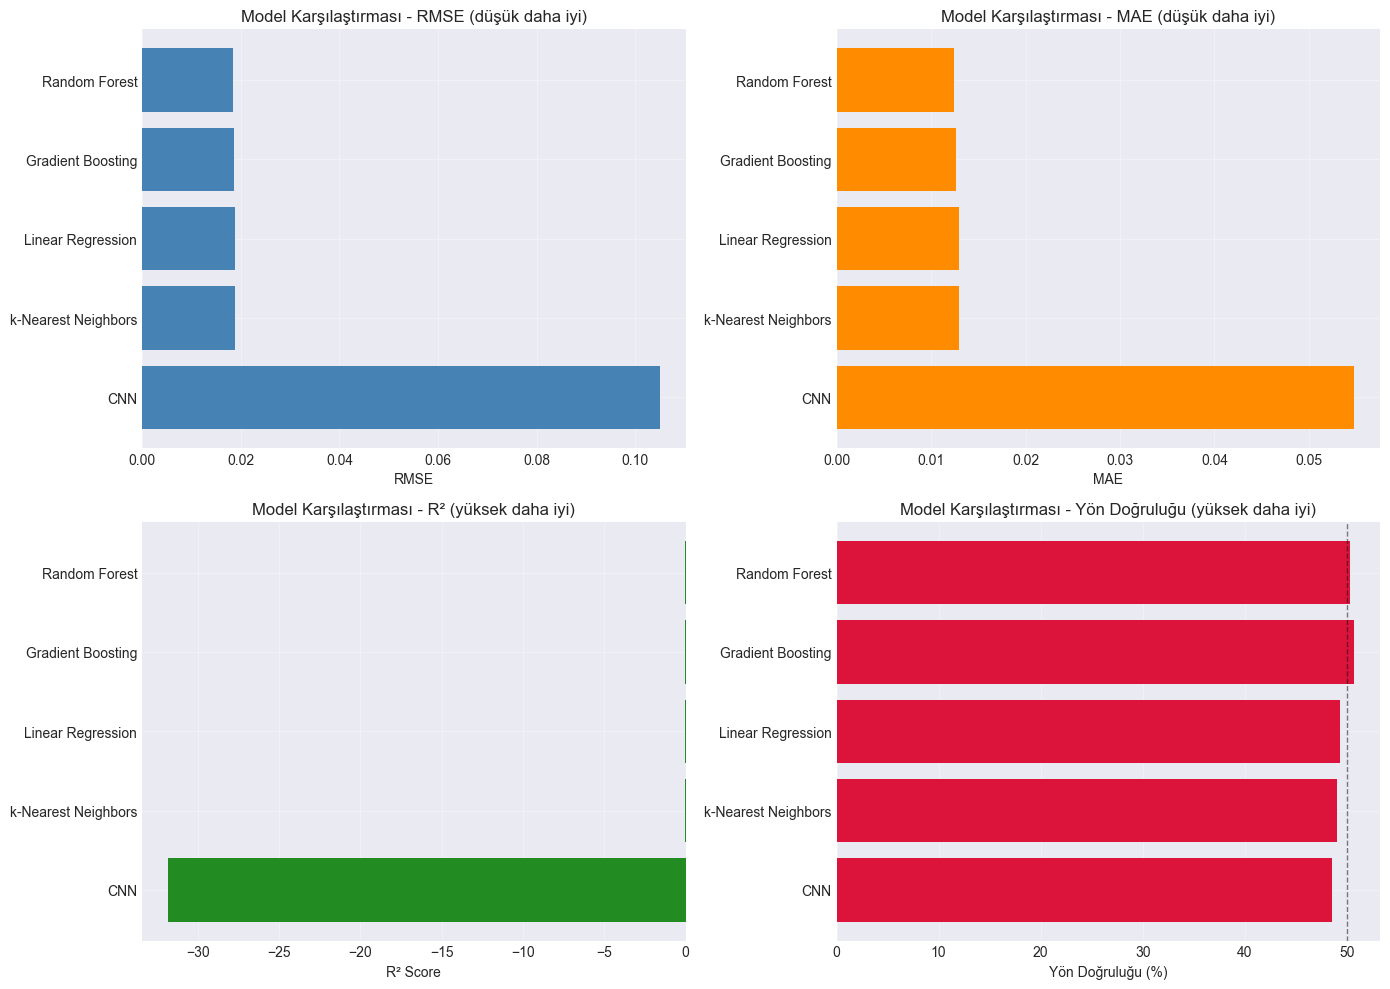

In [21]:
# Görsel karşılaştırma
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# RMSE karşılaştırması
axes[0, 0].barh(results_df['Model'], results_df['RMSE'], color='steelblue')
axes[0, 0].set_xlabel('RMSE')
axes[0, 0].set_title('Model Karşılaştırması - RMSE (düşük daha iyi)')
axes[0, 0].invert_yaxis()
axes[0, 0].grid(alpha=0.3)

# MAE karşılaştırması
axes[0, 1].barh(results_df['Model'], results_df['MAE'], color='darkorange')
axes[0, 1].set_xlabel('MAE')
axes[0, 1].set_title('Model Karşılaştırması - MAE (düşük daha iyi)')
axes[0, 1].invert_yaxis()
axes[0, 1].grid(alpha=0.3)

# R² karşılaştırması
axes[1, 0].barh(results_df['Model'], results_df['R²'], color='forestgreen')
axes[1, 0].set_xlabel('R² Score')
axes[1, 0].set_title('Model Karşılaştırması - R² (yüksek daha iyi)')
axes[1, 0].invert_yaxis()
axes[1, 0].grid(alpha=0.3)

# Yön doğruluğu karşılaştırması
axes[1, 1].barh(results_df['Model'], results_df['Yön Doğruluğu (%)'], color='crimson')
axes[1, 1].set_xlabel('Yön Doğruluğu (%)')
axes[1, 1].set_title('Model Karşılaştırması - Yön Doğruluğu (yüksek daha iyi)')
axes[1, 1].invert_yaxis()
axes[1, 1].axvline(50, color='black', linestyle='--', linewidth=1, alpha=0.5)
axes[1, 1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

## 6. Sonuç ve Yorumlar

### Genel Değerlendirme:

**1. RMSE ve MAE Metrikleri:**
- Düşük RMSE/MAE değeri, modelin tahmin hatalarının küçük olduğunu gösterir
- Finansal zaman serilerinde getiri tahminleri genellikle zorludur

**2. R² Score:**
- R² değeri, modelin varyansın ne kadarını açıkladığını gösterir
- Finansal verilerde düşük R² değerleri normaldir (piyasaların tahmin edilebilirliği sınırlıdır)
- Negatif R² değeri, modelin naif tahminlerden (ortalama) bile kötü olduğunu gösterir

**3. Yön Doğruluğu:**
- %50'nin üzerinde olması önemlidir (rastgele tahmin seviyesinin üstünde)
- Finansal uygulamalarda yön doğruluğu, kar/zarar açısından kritiktir

### Model Özellikleri:

**Linear Regression:**
- En basit model, baseline olarak kullanılabilir
- Doğrusal ilişkiler için yeterli, karmaşık desenler için yetersiz

**Random Forest:**
- Doğrusal olmayan ilişkileri yakalayabilir
- Overfitting'e karşı dirençli
- Özellik önemliliği sağlar

**Gradient Boosting:**
- Genellikle en yüksek performansı sağlar
- Kompleks desenler yakalar
- Dikkatli hiperparametre ayarı gerekir

**k-Nearest Neighbors:**
- Basit ve sezgisel
- Lokal patternleri iyi yakalar
- Büyük veri setlerinde yavaş olabilir

**CNN:**
- Zaman serilerindeki ardışık bağımlılıkları yakalayabilir
- Derin öğrenme yaklaşımı
- Eğitim süresi uzun, yorumlaması zor

### Öneriler:

1. **Ensemble Yaklaşımı:** Birden fazla modelin tahminlerini birleştirmek performansı artırabilir
2. **Özellik Mühendisliği:** Daha fazla teknik gösterge eklemek performansı iyileştirebilir
3. **Hiperparametre Optimizasyonu:** Grid search veya random search ile optimal parametreler bulunabilir
4. **Volatilite Modelleme:** GARCH gibi volatilite modelleriyle birlikte kullanılabilir
5. **Risk Yönetimi:** Model tahminleri, stop-loss ve position sizing stratejileriyle birleştirilmelidir